### How to load the data

This jupyter notebook demonstrates how to access the data of the dataset. To run the notebook you will need to install the following packages:
- pymef (to read MEF3 format)
- pybids (to load the BIDS data structure)


Let's do the imports first

In [198]:
import os

from pymef import MefSession
from bids import BIDSLayout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt


SETTINGS

In [199]:
APPLY_LOW_PASS_FILTER = True
LSTM_READY = False
FEATURE_SET = 1
subject = '003'
run = 2

Now load the BIDS dataset

In [200]:
path_to_dataset = r"C:\MasterThesis\v1.0"  # Please change this value

l = BIDSLayout(path_to_dataset)

Define what data we want to load

In [201]:
filter_dictionary = {'subject': subject,
                     'session': '001',
                     'task': 'FR',
                     'run': run,
                     'suffix': 'ieeg',
                     'extension': 'json'}
json_files = l.get(**filter_dictionary)

# We now we have requested only one file now but multiple files can be processed in a for loop
json_file = json_files[0]
print(json_file)

json_entities = json_file.entities

<BIDSJSONFile filename='C:\MasterThesis\v1.0\sub-003\ses-001\ieeg\sub-003_ses-001_task-FR_run-02_ieeg.json'>


Load information about channels

In [202]:
# Get channels
channel_file = l.get(suffix='channels', extension='tsv',
                     task=json_entities['task'],
                     subject=json_entities['subject'],
                     session=json_entities['session'],
                     run=json_entities['run'])[0]
channel_df = channel_file.get_df()
channel_df = channel_df[channel_df['status'] != 'bad']
channel_df
    

,name,type,units,low_cutoff,high_cutoff,reference,sampling_frequency,status,status_description
0,LEFT_PUPIL_SIZE,PUPIL,px2,NaN,NaN,scalp_cpz,150,good,NaN
1,LEFT_X_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
2,LEFT_Y_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
3,MIC,AUDIO,dBFS,NaN,NaN,scalp_cpz,44100,good,NaN
4,RAH_01,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
...,...,...,...,...,...,...,...,...,...
102,RX_16,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
119,RZ_01,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
120,RZ_02,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
135,SCREEN_X,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN


Load events

In [203]:
events_file = l.get(suffix='events', extension='tsv',
                    task=json_entities['task'],
                    subject=json_entities['subject'],
                    session=json_entities['session'],
                    run=json_entities['run'])[0]
events_df = events_file.get_df()

# Pull only the processed events (discarding the original events)
events_df = events_df.loc[~events_df['trial_type'].isna(), ['onset', 'sample', 'duration', 'trial_type', 'list']]
events_df = events_df[events_df['trial_type'] == 'ENCODE']
events_df = events_df.reset_index(drop=True)
events_df


,onset,sample,duration,trial_type,list
0,283.135183,9060325,1.495874,ENCODE,1.0
1,285.635619,9140339,1.495437,ENCODE,1.0
2,288.135306,9220329,1.495749,ENCODE,1.0
3,290.637305,9300393,1.493781,ENCODE,1.0
4,293.136273,9380360,1.494812,ENCODE,1.0
...,...,...,...,...,...
175,1869.125171,59812005,1.494718,ENCODE,15.0
176,1871.625295,59892009,1.494593,ENCODE,15.0
177,1874.125388,59972012,1.494499,ENCODE,15.0
178,1876.627199,60052070,1.492719,ENCODE,15.0


Now load the raw data

In [204]:
# Since we are using MEF3 pybids has problems recognizing the extension so we need to modify the json extension
mef_session_path = os.path.splitext(json_file.path)[0]+'.mefd'
print(mef_session_path)
ms = MefSession(mef_session_path, None)
ms.read_ts_channel_basic_info()

C:\MasterThesis\v1.0\sub-003\ses-001\ieeg\sub-003_ses-001_task-FR_run-02_ieeg.mefd


[{'name': 'LEFT_PUPIL_SIZE',
  'fsamp': array([150.]),
  'nsamp': array([248465], dtype=int64),
  'ufact': array([1.e-06]),
  'unit': array([b'px2'], dtype='|S128'),
  'start_time': array([1553346702472788], dtype=int64),
  'end_time': array([1553348358906121], dtype=int64),
  'channel_description': array([b'PUPIL'], dtype='|S2048')},
 {'name': 'LEFT_X_COORD',
  'fsamp': array([150.]),
  'nsamp': array([248465], dtype=int64),
  'ufact': array([1.e-06]),
  'unit': array([b'px'], dtype='|S128'),
  'start_time': array([1553346702472788], dtype=int64),
  'end_time': array([1553348358906121], dtype=int64),
  'channel_description': array([b'EYEGAZE'], dtype='|S2048')},
 {'name': 'LEFT_Y_COORD',
  'fsamp': array([150.]),
  'nsamp': array([248465], dtype=int64),
  'ufact': array([1.e-06]),
  'unit': array([b'px'], dtype='|S128'),
  'start_time': array([1553346702472788], dtype=int64),
  'end_time': array([1553348358906121], dtype=int64),
  'channel_description': array([b'EYEGAZE'], dtype='|S20

Now load the data from encoding events

In [205]:
channels = ['LEFT_PUPIL_SIZE', 'RIGHT_PUPIL_SIZE']

# Microseconds 1 μs = 10⁻⁶ s
start_time = 1553941347170839+3*1e6  # in microseconds
end_time = 1553942904095135-3*1e6
win_size = 10  # in seconds
stop_time = start_time + int(win_size*1e6)

bi = ms.read_ts_channel_basic_info()

# In this case we are reading MEF records instead of data from events.tsv because we do not have to make time conversions this way
records = ms.read_records()
records_in_win = [x for x in records if start_time < x['time'] < stop_time]
# The code to get corresponding events from the events file
session_metadata = ms.session_md
session_start_utc = session_metadata['session_specific_metadata']['earliest_start_time'][0]
print(f"session_start_utc = {session_start_utc}\nsession_stop_utc = {stop_time}")
events_df['microsecond_onset'] = events_df['onset']*1e6
events_df['uutc'] = (events_df['microsecond_onset'] + session_start_utc).astype('int64')
events_in_win = events_df[(start_time < events_df['uutc'])
                          & (events_df['uutc'] < stop_time)]
events_df.head()

session_start_utc = 1553346427334605
session_stop_utc = 1553941360170839.0


,onset,sample,duration,trial_type,list,microsecond_onset,uutc
0,283.135183,9060325,1.495874,ENCODE,1.0,283135183.0,1553346710469788
1,285.635619,9140339,1.495437,ENCODE,1.0,285635619.0,1553346712970224
2,288.135306,9220329,1.495749,ENCODE,1.0,288135306.0,1553346715469911
3,290.637305,9300393,1.493781,ENCODE,1.0,290637305.0,1553346717971910
4,293.136273,9380360,1.494812,ENCODE,1.0,293136273.0,1553346720470878


In [206]:
# records_in_events = [x for x in records if (0 < (x['time'] - events_df['uutc']) < 150000)]
records_in_events = []
for x in records:
    for e in events_df['uutc']:
        # print(x['time'] - e)
        if 0 == (x['time'] - e):
            records_in_events.append(x)

len(records_in_events)
data_events = []
# −200ms to 0ms from the onset and from 1000ms to 1400ms
for e in events_df['uutc']:
    data_events.append(ms.read_ts_channels_uutc(channels, [e - 400000, e + 1100000]))
data_events = np.array(data_events)
data_events.shape

(180, 2, 225)

In [207]:
print(data_events[0])

[[1.45874300e+08 1.46978400e+08 1.43817400e+08 1.43817400e+08
  1.43817400e+08 1.47160000e+08 1.47160000e+08 1.47160000e+08
  1.47160000e+08 1.47160000e+08 1.48277499e+08 1.48292400e+08
  1.48292400e+08 1.48292400e+08 1.48292400e+08 1.48292400e+08
  1.48895600e+08 1.48895600e+08 1.48895600e+08 1.48895600e+08
  1.49155000e+08 1.49155000e+08 1.49155000e+08 1.49155000e+08
  1.49155000e+08 1.49155000e+08 1.50712400e+08 1.50712400e+08
  1.48892800e+08 1.49253000e+08 1.58403000e+08 1.58379200e+08
  1.58759900e+08 1.58885800e+08 1.59011700e+08 1.59011700e+08
  1.59011700e+08 1.59127200e+08 1.59127200e+08 1.59127200e+08
  1.57078200e+08 1.56961500e+08 1.59341000e+08 1.59207100e+08
  1.53186800e+08 1.53186800e+08 1.53186800e+08 1.53186800e+08
  1.53186800e+08 1.53186800e+08 1.53186800e+08            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan 1.50348000e+08 1.49518200e+08 1.50047000e+08
  1.5004

## Artefacts cutout

In [208]:
def check_missing_values(arr):
    """Check if a numpy array has missing values."""
    if np.isnan(arr).any():
        print("The array has missing values.")
        return True
    else:
        return False

In [209]:
print(data_events.shape)

(180, 2, 225)


In [210]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        missing_values_idx = []
        for sample_idx, sample in enumerate(channel):
            if np.isnan(sample):
                missing_values_idx.append(sample_idx)
        for missing in missing_values_idx[::-1]:
            if missing >= 5:
                for i in range(5):
                    data_events[s_idx][ch_idx][missing-i] = np.nan
            if missing <= 221:
                for i in range(3):
                    data_events[s_idx][ch_idx][missing+i] = np.nan

## Apply linear interpolation if values are missing

In [211]:
how_many_nan = 0
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if check_missing_values(channel):
            how_many_nan += 1
            df = pd.DataFrame({'signal': channel})
            print(f"Apply linear interpolation to fill the missing values [{s_idx}][{ch_idx}]")
            df['signal'] = df['signal'].bfill().ffill().interpolate(method='linear')
            data_events[s_idx][ch_idx] = df['signal'].values.tolist()
            print(data_events[s_idx][ch_idx])
print(how_many_nan)

The array has missing values.
Apply linear interpolation to fill the missing values [0][0]
[1.45874300e+08 1.46978400e+08 1.43817400e+08 1.43817400e+08
 1.43817400e+08 1.47160000e+08 1.47160000e+08 1.47160000e+08
 1.47160000e+08 1.47160000e+08 1.48277499e+08 1.48292400e+08
 1.48292400e+08 1.48292400e+08 1.48292400e+08 1.48292400e+08
 1.48895600e+08 1.48895600e+08 1.48895600e+08 1.48895600e+08
 1.49155000e+08 1.49155000e+08 1.49155000e+08 1.49155000e+08
 1.49155000e+08 1.49155000e+08 1.50712400e+08 1.50712400e+08
 1.48892800e+08 1.49253000e+08 1.58403000e+08 1.58379200e+08
 1.58759900e+08 1.58885800e+08 1.59011700e+08 1.59011700e+08
 1.59011700e+08 1.59127200e+08 1.59127200e+08 1.59127200e+08
 1.57078200e+08 1.56961500e+08 1.59341000e+08 1.59207100e+08
 1.53186800e+08 1.53186800e+08 1.53186800e+08 1.50047000e+08
 1.50047000e+08 1.50047000e+08 1.50047000e+08 1.50047000e+08
 1.50047000e+08 1.50047000e+08 1.50047000e+08 1.50047000e+08
 1.50047000e+08 1.50047000e+08 1.50047000e+08 1.5004700

## Connect windows to continuous signal across channels

In [212]:
channel_1_raw = []
channel_2_raw = []
for s_idx, sequence in enumerate(data_events):
    for sample in data_events[s_idx][0]:
        channel_1_raw.append(sample)
    for sample in data_events[s_idx][1]:
        channel_2_raw.append(sample)
channel_1_raw = np.array(channel_1_raw)
channel_2_raw = np.array(channel_2_raw)
channel_1_raw.shape

(40500,)

### Apply z-score normalization

In [213]:
mean = np.mean(channel_1_raw)
std = np.std(channel_1_raw)
data_normalized = (channel_1_raw - mean) / std
channel_1_raw = data_normalized

mean = np.mean(channel_2_raw)
std = np.std(channel_2_raw)
data_normalized = (channel_2_raw - mean) / std
channel_2_raw = data_normalized

### Split again into windows

In [214]:
def split_list(lst, n):
    """Split the list, lst, into chunks of size n."""
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [215]:
samples_in_window = 225
chunks_1 = split_list(channel_1_raw, samples_in_window)
chunks_2 = split_list(channel_2_raw, samples_in_window)
print(len(chunks_1))

180


In [216]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if ch_idx == 0:
            data_events[s_idx][ch_idx] = chunks_1[s_idx]
        elif ch_idx == 1:
            data_events[s_idx][ch_idx] = chunks_2[s_idx]
data_events = np.array(data_events)
print(data_events.shape)

(180, 2, 225)


In [217]:
print(data_events[0][0][0])

nan


## Plot the window

In [218]:
def plot_channels(data):
    # assuming 'data' is your list
    data = np.array(data)  # convert list to numpy array
    print(data.shape)
    time = np.arange(0, data.shape[1])  # creating a time vector

    # plotting the data
    plt.figure(figsize=(10,6))  # creating a new figure with specified size
    print(data[0])
    # plot for channel 1
    plt.subplot(2, 1, 1)  # creating the first subplot in a 2x1 grid
    plt.plot(time, data[0], color='blue')  # plotting the data for the first channel
    plt.title('Channel 1')  # setting the title of the first subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    # plot for channel 2
    plt.subplot(2, 1, 2)  # creating the second subplot in a 2x1 grid
    plt.plot(time, data[1], color='red')  # plotting the data for the second channel
    plt.title('Channel 2')  # setting the title of the second subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    plt.tight_layout()  # adjusting the layout so everything fits
    plt.show()  # displaying the figure

(2, 225)
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]


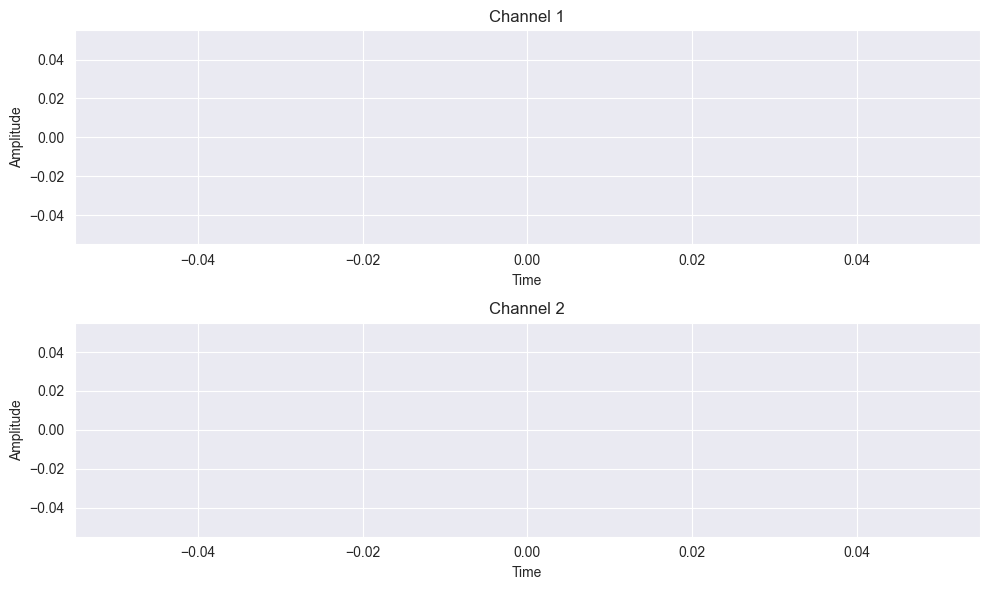

In [219]:
plot_channels(data_events[0])

## Define and apply butterworth filter

In [220]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parameters
order = 3
fs = 150.0       # sample rate, Hz
cutoff = 20.0    # desired cutoff frequency of the filter, Hz


In [221]:
if APPLY_LOW_PASS_FILTER:
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            y = butter_lowpass_filter(channel, cutoff, fs, order)
            data_events[s_idx][ch_idx] = y

(2, 225)
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]


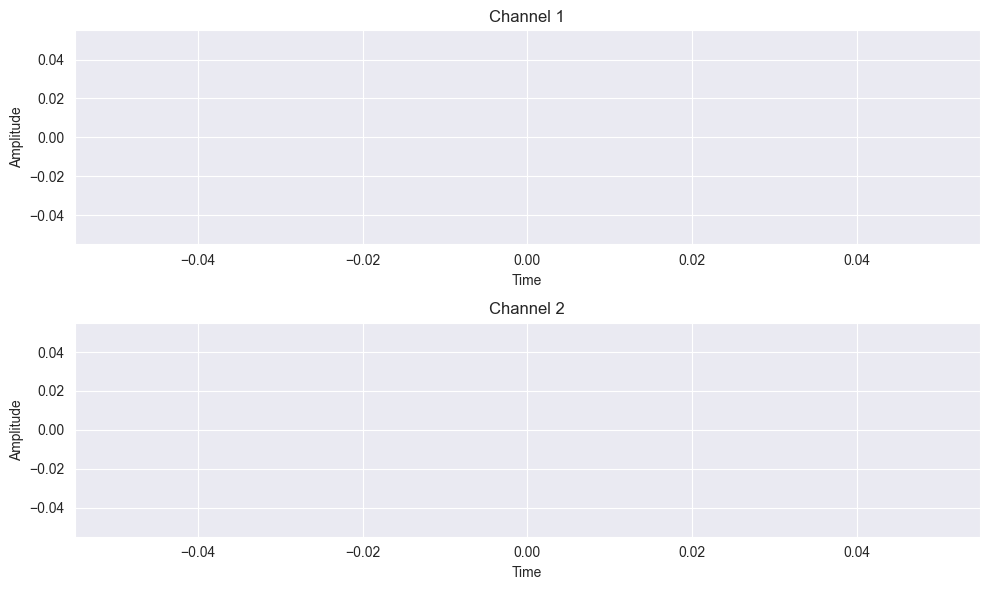

In [222]:
plot_channels(data_events[0])

## Feature extraction

### Feature set 1
https://www.hindawi.com/journals/cin/2020/2909267/

In [223]:
import mne

if FEATURE_SET == 1:
    sfreq = 150  # replace with your sampling frequency
    # delta: 2.5-5 Hz, theta: 4–9 Hz, alpha: 9–16 Hz, beta: 16–25 Hz,
    freqs = [16., 25., 40.]  # define the range of frequency bands
    # freqs = [5.]
    print(freqs)
    n_cycles = 7.0

    # perform Morlet Wavelet transform
    power = mne.time_frequency.tfr_array_morlet(data_events, sfreq, freqs, n_cycles=n_cycles)
    power = np.mean(power, axis=1)

    # n_samples * n_channels * n_frequencies * n_times
    # power = 10 * np.log10(power)
# power.shape

[16.0, 25.0, 40.0]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


### Feature set 2 - 6 features
https://www.mdpi.com/2227-9032/11/3/322

In [224]:
from scipy.stats import skew, kurtosis, variation


if FEATURE_SET == 2 and not LSTM_READY:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            q1 = np.percentile(eeg_data, 25)
            q2 = np.percentile(eeg_data, 50)
            q3 = np.percentile(eeg_data, 75)
            min_signal = np.min(eeg_data)
            max_signal = np.max(eeg_data)
            # variance = variation(eeg_data)
            # skewness = skew(eeg_data)

            features = [mean, q1, q2, q3, min_signal, max_signal]

            # print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

### Feature set 3 - 4 features
https://www.hindawi.com/journals/cin/2020/2909267/

In [225]:

if FEATURE_SET == 3:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            variance = variation(eeg_data)
            skewness = skew(eeg_data)
            # kurtosis = kurtosis(eeg_data)

            features = [mean, variance, skewness]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

## Reshape to dataframe

In [226]:
power.shape

(180, 3, 225)

In [227]:

power_magnitude = np.abs(power)
# convert to a decibel scale, which is often done for power spectral densities:
power_db = 10 * np.log10(power_magnitude)
arr = np.array(power_db)

# Reshape the array to the required shape (180, 450)
arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension

df = pd.DataFrame(arr_reshaped)

# Now df is a DataFrame with shape (180, 450)
print(df.shape)

(180, 675)


In [228]:
# arr = np.array(data_events)
#
#     # Reshape the array to the required shape (180, 450)
# arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension
#
# df = pd.DataFrame(arr_reshaped)
#
#     # Now df is a DataFrame with shape (180, 450)
# print(df.shape)

In [229]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,665,666,667,668,669,670,671,672,673,674
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
df.to_csv(rf'C:\MasterThesis\v1.0\sub-{subject}\ses-001\{subject}_{run}_pupil_dataset.csv', index=False)